# Workout Analysis

## EDA

### Importing Packages and Reading in Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
session_data = pd.read_csv('data/sessions.csv')
exercise_data = pd.read_csv('data/exercise.csv')

### Data Wrangling/Cleaning

In [4]:
data = pd.merge(session_data, exercise_data, left_on = 'Date', right_on = 'Date')

# convert dataframe columns to snake case
def to_snake_case(column):
    return (
        column.strip()
        .replace(" ", "_")
        .replace(".", "")
        .replace("-", "_")
        .lower()
    )

# Rename columns using the function
data.rename(columns=lambda col: to_snake_case(col), inplace=True)
session_data.rename(columns = lambda col: to_snake_case(col), inplace=True)

In [5]:
# Define conditions and corresponding workout types
conditions = [
    data['exercise'].isin(['Bench Press', 'Pause Bench Press', 'Incline Bench Press', 'Dumbbell Shoulder Press', 'Dumbbell Bench Press', 'Incline Dumbbell Bench Press', 'Lateral Raises', 'Chest Supported Lateral Raises', 'Pec Fly Machine', 'Egyptian Cable Lateral Raise', 'Horizontal Cable Lateral Raise', 'Lateral Raise Machine', 'Skullcrushers', 'Tricep Pushdown', 'Tricep Extensions', 'Cable Fly', 'Decline Cable Flies', 'Dips', 'Dumbbell Skullcrushers', 'Supported Incline Cable Flies', 'Military Press', 'Horizontal Cable Lateral Raise (Blom)', 'Push Ups', 'Smith Machine Incline Bench Press', 'Overhead Tricep Extension', 'Seated Overhead Press']),
    data['exercise'].isin(['Deadlift', 'Pull Ups', 'Lat Pulldown', 'Lat Pulldown Machine', 'Weight Assisted Pullups', 'Standing Lat Pullover', 'Single Arm Front Pulldown', 'Single Arm Pulldown', 'Single Arm Chest Supported Row Machine', 'Cable Row', 'Row Machine', 'Barbell Row', 'Dumbbell Row', 'Dumbbell Upright Row', 'Bicep Curls', 'Preacher Curls', 'Hammer Curl', 'EZ Bar Curls', 'Face Pulls', 'Rear Delt Cable Flies', 'Rear Delt Fly', 'Rear Delt Fly Machine', 'Lower Back Extension', 'Incline Bicep Curls', 'Rear Delt Cable Flies', 'Rear Delt Cable Flies (Blom)', 'Front Pulldown', 'Cable Bicep Curls', 'High Cable Row', 'Bent Over Dumbbell Row', 'Barbell Upright Row', 'Cable Lat Pullover', 'Single Arm Standing Chest Supported Cable Row', 'Dumbbell Preacher Curls']),
    data['exercise'].isin(['Barbell Squat', 'Smith Machine Barbell Squat', 'Leg Press Machine', 'Horizontal Leg Press Machine', 'RDL', 'Quad Extension Machine', 'Bulgarian Split Squats', 'Dumbbell Split Squats', 'Hamstring Curl Machine', 'Prone Hamstring Curls', 'Calf Raises', 'Single Leg Calf Raises', 'Calf Extension Machine', 'Glute Kickback Machine', 'Hip Abduction Machine', 'Hip Adduction Machine', 'Torso Rotation Machine', 'Leg Raises', 'Hanging Leg Raises', 'Hanging Knee Raises', 'Ab Crunch Machine', "Captain's Chair Hanging Leg Raises", 'Cable Crunches', 'Hanging Crunches']),
    data['exercise'].isin(['Stairmaster', 'Bike'])
]
choices = ['Push', 'Pull', 'Legs', 'Cardio']

# Create the new column
data['workout_type'] = np.select(conditions, choices, default=data.exercise)

In [ ]:
# Pivoting the table on weight and reps
long_data = data.melt(
    id_vars=[col for col in data.columns if not col.startswith("set_")],  # Keep all other columns
    value_vars=[col for col in data.columns if col.startswith("set_")],  # Only the set columns
    var_name="set_detail",
    value_name="value"
)

# Step 2: Extract the set number and type (weight or reps) from set_detail
long_data["set"] = long_data["set_detail"].str.extract(r"set_(\d+)_")[0].astype(int)
long_data["type"] = long_data["set_detail"].str.extract(r"set_\d+_(\w+)")[0]

# Step 3: Pivot the data to get weight and reps as separate columns for each set
pivot_data = long_data.pivot(
    # Keep non-set related columns
    columns=["set", "type"],  # Set number and type as columns
    values="value"
)

# create separate dataframes for weight and reps
df_weight = long_data[long_data['type'] == 'weight'].drop(columns='type')
df_reps = long_data[long_data['type'] == 'reps'].drop(columns='type')

# Merge the weight and reps dataframes on the common columns
set_df = pd.merge(df_weight, df_reps, on=['date', 'duration', 'starting_time', 'energy_level', 'fasted', 'group', 'preworkout', 'location', 'comments_x', 'comments_y', 'exercise', 'set', 'exercise', 'workout_type'], suffixes=('_weight', '_reps'))

# rename columns
set_df = set_df.rename(columns = {'value_reps': 'reps', 'value_weight': 'weight'})

# removing original columns
set_df = set_df.drop(['set_detail_reps', 'set_detail_weight'], axis = 1)

# drop NA values
set_df = set_df.dropna(subset=['weight', 'reps'])


# converting weight and reps to floats
set_df['weight'] = set_df['weight'].astype(str).str.split('/').str[0]  # Keep only the first number before the slash
set_df['reps'] = set_df['reps'].astype(str).str.split(' &').str[0] 
set_df['reps'] = set_df['reps'].astype(str).str.split('/').str[0] 

set_df['weight'] = set_df['weight'].astype('float64')
set_df['reps'] = set_df['reps'].astype('float64')

### Distribution Exploration

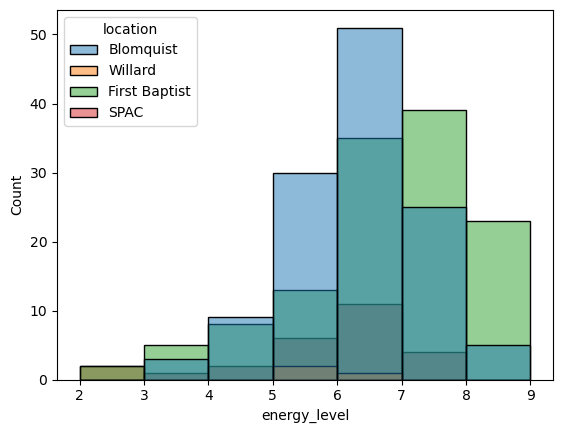

In [8]:
plot = sns.histplot(data=session_data,
                    x = 'energy_level',
                    bins = 7,
                    kde = False,
                    hue = 'location')

- Energy Level is left skew with mean around 6-7 out of 10

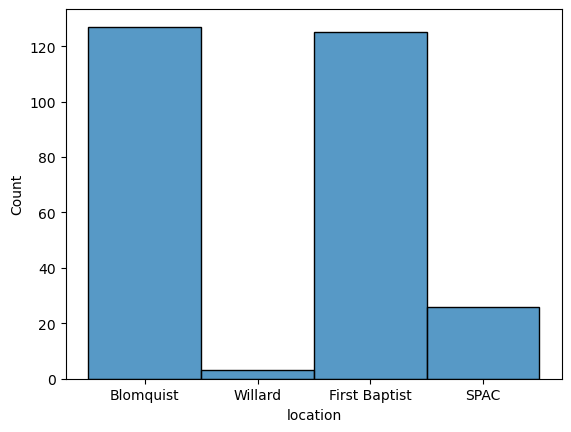

In [9]:
plot = sns.histplot(data = session_data,
                    x = "location")

- Large majority of workouts at Blomquist or First Baptist

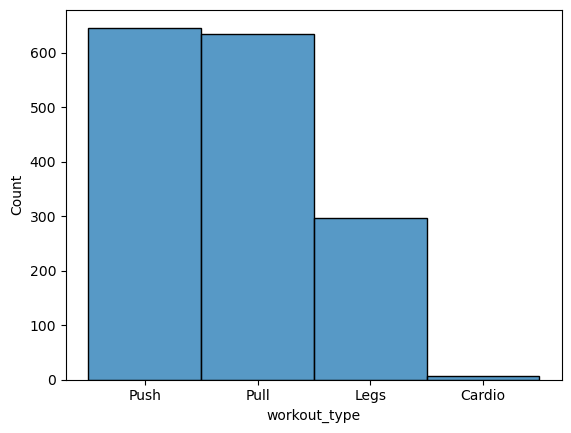

In [10]:
plot = sns.histplot(data = data,
                    x = 'workout_type')

- Roughly equal amount of Push and Pull workouts \n
- Almost half as many Leg workouts

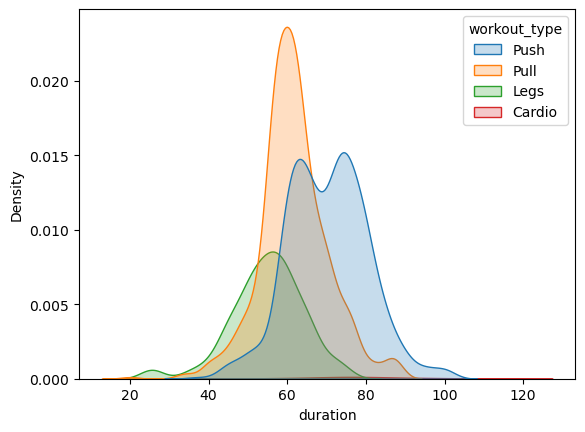

In [11]:
plot = sns.kdeplot(data = data,
                    x = 'duration',
                    fill = True,
                    hue = 'workout_type')

- Intersetingly, Push workouts seem to be bimodally distributed around 60 and 80 minutes
    - Lets explore this further...
- Pull workouts are generally normally distributed around 60 minutes
- Legs workouts are slightly left skew with a peak slightly below 60 minutes as well

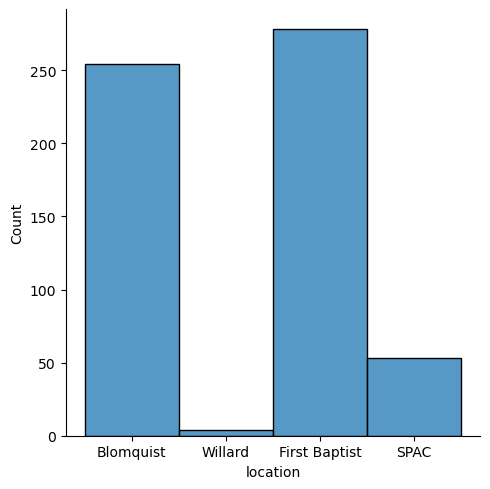

In [12]:
plot = sns.displot(data = data[data['workout_type'] == 'Push'],
                   x = 'location')

- Similarly to the distribution of all workout types, most Push workouts occur at Blomquist or First Baptist

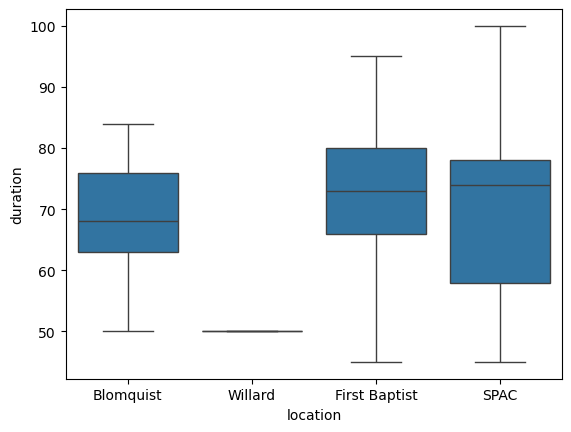

In [13]:
plot = sns.boxplot(data = data[data['workout_type'] == 'Push'],
                   x = 'location',
                   y = 'duration')

- We can see that Push workouts at First Baptist and SPAC generally last longer than those at Blomquist, likely accounting for the bimodal distribution observed earlier

### Weights and Reps

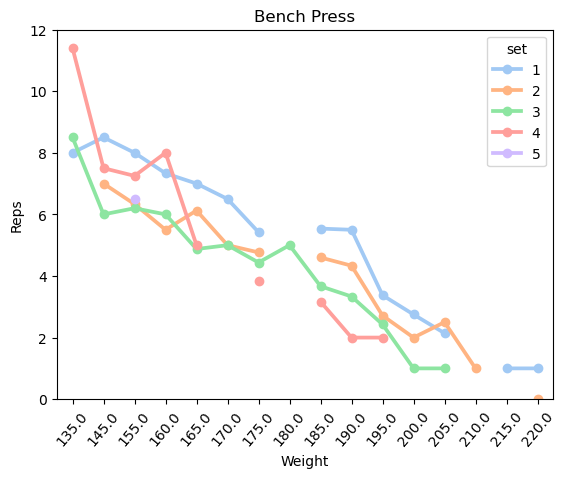

In [67]:
plot = sns.pointplot(data = set_df[set_df.exercise == 'Bench Press'],
                   y = 'reps',
                   x = 'weight',
                   hue = 'set',
                   markersize = 5,
                   palette = 'pastel',
                   errorbar = None)
plot.set(ylabel = 'Reps',
         xlabel = 'Weight',
         title = 'Bench Press',
         ylim = [0, 12])
plot.tick_params(axis = 'x', labelrotation = 50)


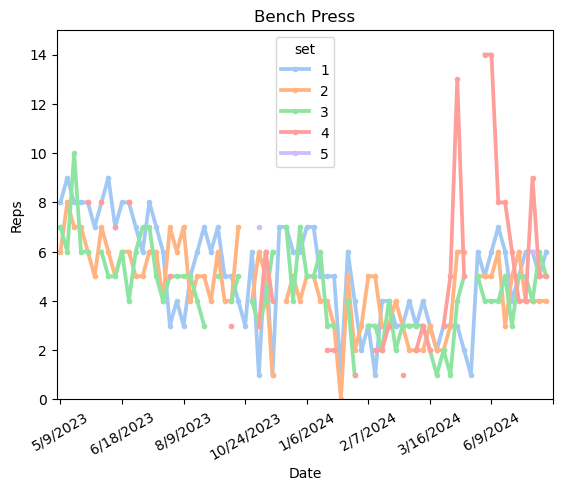

In [ ]:
plot = sns.pointplot(data = set_df[set_df.exercise == 'Bench Press'],
                   y = 'reps',
                   x = 'date',
                   hue = 'set',
                   palette = 'pastel',
                   markersize = 2,
                   errorbar = None)
plot.set(ylabel = 'Reps',
         xlabel = 'Date',
         title = 'Bench Press',
         ylim = [0, 15],
         xticks = range(0, 80, 9))
plot.tick_params(axis = 'x', labelrotation = 30)


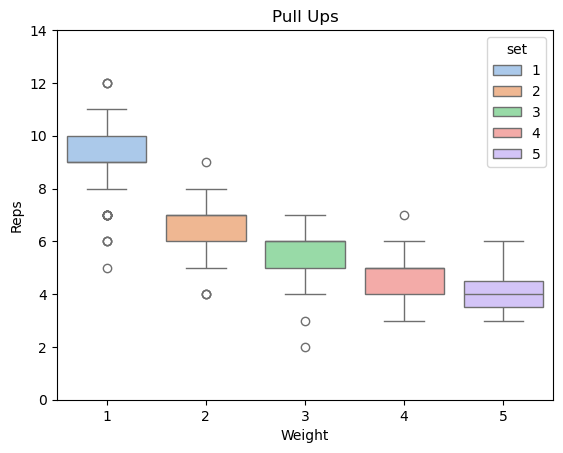

In [ ]:
plot = sns.boxplot(data = set_df[set_df.exercise == 'Pull Ups'],
                   y = 'reps',
                   x = 'set',
                   hue = 'set',
                   palette = 'pastel')
plot.set(ylabel = 'Reps',
         xlabel = 'Set',
         title = 'Pull Ups',
         ylim = [0, 14])
plot.tick_params(axis = 'x', labelrotation = 0)
